# Set up

In [12]:
!pip install -U ffmpeg youtube-dl cuda torch_optimizer

     |████████████████████████████████| 1.9 MB 8.4 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=9feff4c7c14f15790419b853625a77377c161c635952c42a800306f528e9aedc
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
  Created wheel for cuda: filename=cuda-0.0.1-py3-none-any.whl size=1170 sha256=4e359e7b34a06d389ddb133f731029e02791df1e0684124d24ade50b4fabbf25
  Stored in directory: /root/.cache/pip/wheels/58/66/7d/152049687c7376a7681a770e99f46ab09d45098826ecc4941d
Successfully built ffmpeg cuda


In [13]:
!git clone https://github.com/commaai/speedchallenge.git
!rm speedchallenge/data/train.mp4
!youtube-dl -f mp4 -o speedchallenge/data/train.mp4 https://youtu.be/LMJHVc3fpo4
#!rm speedchallenge/data/test.mp4
#!youtube-dl -f mp4 -o speedchallenge/data/test.mp4 https://youtu.be/FcAbi_mutTA

Cloning into 'speedchallenge'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (14/14), done.
[youtube] LMJHVc3fpo4: Downloading webpage
[youtube] LMJHVc3fpo4: Downloading MPD manifest
[download] Destination: speedchallenge/data/train.mp4
[download] 100% of 49.39MiB in 00:04


In [14]:
!mkdir clean-images
!mkdir assets
!mkdir clean-images/train
!mkdir clean-images/test
!mkdir clean-images/processed
!mkdir clean-images/kitti

# Imports

In [15]:
import numpy as np
import tensorflow as tf
import cv2
import csv
import os
import time
import json
import copy
import shutil
import subprocess
import string
import random
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image 
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py
import torch
from torch import nn, flatten
from torch.autograd import Variable
from torch.nn import Module, Linear, Conv2d, MaxPool2d, Dropout, ELU, MSELoss, Sequential
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
import torchvision as tv
from torch_optimizer import DiffGrad, NovoGrad, SWATS, Yogi, AdaBound
from scipy.special import expit, logit

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
drive.mount('/content/gdrive')

# KITTI dataset

In [16]:
kittiLink = lambda x, d:'https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/{}_drive_{:0>4}/{}_drive_{:0>4}_sync.zip'.format(d, x, d, x)
kittiZip = lambda x, d:'{}_drive_{:0>4}_sync.zip'.format(d, x)
kittiPath = lambda x, d:os.path.join(d, '{}_drive_{:0>4}_sync'.format(d, x))

FRAME_RATE_1 = cv2.VideoCapture('speedchallenge/data/train.mp4').get(cv2.CAP_PROP_FPS)
FRAME_RATE_2 = 10

In [17]:
def getKITTI(basePath, destPath):
  COLS = (
      'lat',
      'lon',
      'alt',
      'roll',
      'pitch',
      'yaw',
      'vn',
      've',
      'vf',
      'vl',
      'vu',
      'ax',
      'ay',
      'az',
      'af',
      'al',
      'au',
      'wx',
      'wy',
      'wz',
      'wf',
      'wl',
      'wu',
      'pos_accuracy',
      'vel_accuracy',
      'navstat',
      'numsats',
      'posmod',
      'velmode',
      'orimode'
  )

  def getKITTI_1():
    i = 0
    while True:
      curFile = '{:0>10}.txt'.format(i)
      i += 1
      path = os.path.join(basePath, 'oxts', 'data', curFile)
      if not os.path.isfile(path):
        break
      with open(path, 'r') as f:
        yield {col:val for col, val in zip(COLS, f.read().replace('\n', '').split(' '))}
  df = pd.DataFrame(list(getKITTI_1()), columns=COLS)
  for col in COLS:
    df[col] = pd.to_numeric(df[col])

  def getKITTI_2():
    with open(os.path.join(basePath, 'oxts', 'timestamps.txt')) as f:
      for line in f.readlines():
        yield line

  df['timestamp'] = pd.to_datetime(pd.Series(getKITTI_2()))

  def getKITII_image(imgDir):
    i = 0
    while True:
      fileName = '{:0>10}.png'.format(i)
      i += 1
      path = os.path.join(basePath, imgDir, 'data', fileName)
      if not os.path.isfile(path):
        break
      #yield Image.open(path)
      while True:
        new_path = os.path.join(destPath, ''.join(random.choice(string.digits + string.ascii_letters) for i in range(10)) + '.jpg')
        if not os.path.isfile(new_path):
          shutil.move(path, new_path)
          yield new_path
          break
      #yield path
  df['Image'] = pd.Series(getKITII_image('image_02'))
  df['Image Previous'] = [None, ] + list(df['Image'])[:-1]
  df['Image Next'] = list(df['Image'])[1:] + [None,]

  return df

#for item in getKITTI(join('2011_09_26', '2011_09_26_drive_0001_sync')):
# print(item)
def getKITTI2(x,d, dest):
  try:
    if os.system('wget {}'.format(kittiLink(x, d))) != 0 or not os.path.isfile(kittiZip(x, d)):
      return pd.DataFrame()
    if os.system('unzip {}'.format(kittiZip(x, d))) != 0:
      return pd.DataFrame()
    data = getKITTI(kittiPath(x, d), dest)
    os.system('rm {}'.format(kittiZip(x, d)))
    shutil.rmtree(kittiPath(x, d))
    return data
  except Exception as e:
    if type(e) == KeyboardInterrupt:
      raise e
    print(type(e))
    print('Failed on {}, {}, {}: {}'.format(x, d, dest, e))
    return pd.DataFrame()
#kittiDF = getKITTI2(1, '2011_09_26', 'clean-images/kitti')
kittiDF = [getKITTI2(i, '2011_09_26', 'clean-images/kitti') for i in tqdm(range(1, 31), 'Downloading KITTI PATHS')]
kittiDF = [x for x in kittiDF if len(x.index) > 0]
#kittiDF = pd.concat(
#    getKITTI2(i, '2011_09_26', 'clean-images/kitti') for i in tqdm(range(1, 120), 'KITTI 9/26/2011')
#).reset_index(drop=True)

# Preprocessing

In [18]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [19]:
'''
This needs to be modified to account for input images of all sizes
'''
def resize_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [20]:
'''
Code from https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
'''
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [21]:
def preprocess_image_from_path(image_path, speed, bright_factor, rot_ang):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = rotate_image(img, rot_ang)
    img = change_brightness(img, bright_factor)    
    img = resize_image(img)
    return img, speed

# Farneback Method Optical Flow

In [22]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

# Dataset Construction

In [23]:
def video_to_frames(video_path, img_folder):
  class getFrames():
    def __init__(self):
      self.vid = cv2.VideoCapture(video_path)
    def __iter__(self):
      return self
    def __next__(self):
      con, frame = self.vid.read()
      if con:
        return frame
      else:
        raise StopIteration
    def __len__(self):
      return int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))

  frame_paths = list()
  for idx, frame in enumerate(tqdm(getFrames(), 'Converting video to still frames')):
    img_path = os.path.join(img_folder, str(idx)+'.jpg')
    cv2.imwrite(img_path, frame) 
    frame_paths.append(img_path)
  
  return frame_paths

In [24]:
class Dataset_Custom(torch.utils.data.Dataset):
  def __init__(self, image_paths, speeds, preprocessing_step, optical_flow_step, vary_brightness=False):
    super(Dataset_Custom).__init__()
    assert len(image_paths) == len(speeds), 'lengths {}, {} do not match'.format(len(image_paths), len(speeds))
    self.image_paths = image_paths
    self.speeds = speeds
    self.preprocessing_step = preprocessing_step
    self.optical_flow_step = optical_flow_step
    self.vary_brightness = vary_brightness

  def __len__(self):
    return len(self.speeds) - 1

  def __getitem__(self, idx):
    if idx < 0 or idx >= len(self):
      raise IndexError('index {} is out of bounds (len={})'.format(idx, len(self)))

    image_now = self.image_paths[idx]
    image_next = self.image_paths[idx + 1]

    speed_now = self.speeds[idx]
    speed_next = self.speeds[idx + 1]


    bright_factor = 1.0
    if self.vary_brightness:
      bright_factor = 0.2 + np.random.uniform()

    x1, y1 = self.preprocessing_step(image_now, speed_now, bright_factor)
    x2, y2 = self.preprocessing_step(image_next, speed_next, bright_factor)

    rgb_diff = self.optical_flow_step(x1, x2)
    y = np.mean([y1, y2])

    return (tv.transforms.ToTensor()(rgb_diff), float(y))

In [25]:
def preprocess_images(image_paths, target_dir, speeds, preprocessing_step, optical_flow_step, vary_brightness=False):
  for idx in tqdm(range(len(image_paths) - 1), 'Preprocessing Images'):
    image_now = image_paths[idx]
    image_next = image_paths[idx + 1]
    
    speed_now = speeds[idx]
    speed_next = speeds[idx + 1]
    
    bright_factor = 1.0
    rot_ang = 0.0
    if vary_brightness:
      bright_factor = np.random.uniform(0.2, 1.2)
      rot_ang = np.random.uniform(-10.0, 10.0)

    x1, y1 = preprocessing_step(image_now, speed_now, bright_factor, rot_ang)
    x2, y2 = preprocessing_step(image_next, speed_next, bright_factor, rot_ang)

    rgb_diff = optical_flow_step(x1, x2)

    new_path = None
    while new_path is None or os.path.isfile(new_path):
      new_path = '{}/{}.png'.format(target_dir, ''.join(random.choice(string.digits + string.ascii_letters) for i in range(10)))
    cv2.imwrite(new_path, rgb_diff)

    y = np.mean([y1, y2])

    yield y, new_path

In [26]:
class Dataset_Custom_Fast(torch.utils.data.Dataset):
  def __init__(self, image_paths, speeds):
    super(Dataset_Custom_Fast).__init__()
    assert len(image_paths) == len(speeds), 'lengths {}, {} do not match'.format(len(image_paths), len(speeds))
    self.image_paths = image_paths
    self.speeds = speeds

  def __len__(self):
    return len(self.speeds)

  def __getitem__(self, idx):
    if idx < 0 or idx >= len(self):
      raise IndexError('index {} is out of bounds (len={})'.format(idx, len(self)))

    return (tv.transforms.ToTensor()(cv2.imread(self.image_paths[idx])), float(self.speeds[idx]))

In [27]:
TRAIN_RATIO = 0.7

comma_frames = video_to_frames('speedchallenge/data/train.mp4', 'clean-images/train')
comma_speeds = list(pd.read_csv('speedchallenge/data/train.txt', header=None, squeeze=True))
comma_speeds, comma_frames = zip(*preprocess_images(comma_frames, 'clean-images/processed', \
                                                    comma_speeds, preprocess_image_from_path, \
                                                    opticalFlowDense, True))

comma_frames_train, comma_frames_valid, comma_speeds_train, comma_speeds_valid = train_test_split(comma_frames, comma_speeds, train_size=TRAIN_RATIO)

Converting video to still frames:   0%|          | 0/20400 [00:00<?, ?it/s]

Preprocessing Images:   0%|          | 0/20399 [00:00<?, ?it/s]

In [28]:
kitti_frames, kitti_speeds = [], []
for i, df in enumerate(kittiDF):
  kitti_frames.append(None)
  kitti_speeds.append(None)
  print('Trip {}/{}: {} frames'.format(i + 1, len(kittiDF), len(kittiDF[i]['Image'])))
  kitti_frames[i], kitti_speeds[i] = kittiDF[i]['Image'], kittiDF[i]['vf']
  kitti_speeds[i], kitti_frames[i] = zip(*preprocess_images(kitti_frames[i], 'clean-images/processed', \
                                                    kitti_speeds[i], preprocess_image_from_path, \
                                                    opticalFlowDense, False))

Trip 1/17: 108 frames


Preprocessing Images:   0%|          | 0/107 [00:00<?, ?it/s]

Trip 2/17: 77 frames


Preprocessing Images:   0%|          | 0/76 [00:00<?, ?it/s]

Trip 3/17: 154 frames


Preprocessing Images:   0%|          | 0/153 [00:00<?, ?it/s]

Trip 4/17: 447 frames


Preprocessing Images:   0%|          | 0/446 [00:00<?, ?it/s]

Trip 5/17: 233 frames


Preprocessing Images:   0%|          | 0/232 [00:00<?, ?it/s]

Trip 6/17: 144 frames


Preprocessing Images:   0%|          | 0/143 [00:00<?, ?it/s]

Trip 7/17: 314 frames


Preprocessing Images:   0%|          | 0/313 [00:00<?, ?it/s]

Trip 8/17: 297 frames


Preprocessing Images:   0%|          | 0/296 [00:00<?, ?it/s]

Trip 9/17: 114 frames


Preprocessing Images:   0%|          | 0/113 [00:00<?, ?it/s]

Trip 10/17: 270 frames


Preprocessing Images:   0%|          | 0/269 [00:00<?, ?it/s]

Trip 11/17: 481 frames


Preprocessing Images:   0%|          | 0/480 [00:00<?, ?it/s]

Trip 12/17: 86 frames


Preprocessing Images:   0%|          | 0/85 [00:00<?, ?it/s]

Trip 13/17: 800 frames


Preprocessing Images:   0%|          | 0/799 [00:00<?, ?it/s]

Trip 14/17: 474 frames


Preprocessing Images:   0%|          | 0/473 [00:00<?, ?it/s]

Trip 15/17: 188 frames


Preprocessing Images:   0%|          | 0/187 [00:00<?, ?it/s]

Trip 16/17: 430 frames


Preprocessing Images:   0%|          | 0/429 [00:00<?, ?it/s]

Trip 17/17: 430 frames


Preprocessing Images:   0%|          | 0/429 [00:00<?, ?it/s]

# NVIDIA CNN

In [29]:
class nvidia_cnn(Module):
  def __init__(self):
    super(nvidia_cnn, self).__init__()

    self.conv1 = Conv2d(3, 24,
        kernel_size=(5, 5),
        stride=(2, 2),
        padding='valid'
        )
    self.elu1 = ELU()
    self.conv2 = Conv2d(24, 36,
        kernel_size=(5, 5),
        stride=(2,2),
        padding='valid'
    )
    self.elu2 = ELU()
    self.conv3 = Conv2d(36, 48,
        kernel_size=(5, 5),
        stride=(2, 2),
        padding='valid',
    )
    self.elu3 = ELU()
    self.dropout1 = Dropout(0.5)
    self.conv4 = Conv2d(48, 64,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding='valid'
    )
    self.elu4 = ELU()
    self.conv5 = Conv2d(64, 64,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding='valid'
    )
    self.elu5 = ELU()
    self.fc0 = Linear(1280, 100)
    self.elu6 = ELU()
    self.fc1 = Linear(100, 50)
    self.elu7 = ELU()
    self.fc2 = Linear(50, 10)
    self.elu8 = ELU()
    self.fc3 = Linear(10, 1)
    self.elu9 = ELU()

  def forward(self, x, device):
    x = self.conv1(x)
    x = self.elu1(x)
    x = self.conv2(x)
    x = self.elu2(x)
    x = self.conv3(x)
    x = self.elu3(x)
    x = self.dropout1(x)
    x = self.conv4(x)
    x = self.elu4(x)
    x = self.conv5(x)
    x = flatten(x, 1)
    x = self.elu5(x)
    x = self.fc0(x)
    x = self.elu6(x)
    x = self.fc1(x)
    x = self.elu7(x)
    x = self.fc2(x)
    x = self.elu7(x)
    x = self.fc3(x)
    x = self.elu9(x)
    x = flatten(x)
    return x

# Training

In [30]:
EPOCHS = 100
NUM_BATCHES = 64 #Not implemented
BATCH_SIZE = 8

history = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is {}'.format(device))


#train_loader = Dataset_Custom( \
#    comma_frames_train, comma_speeds_train, preprocess_image_from_path, \
#    opticalFlowDense, True
#    )
train_loader = Dataset_Custom_Fast(comma_frames_train, comma_speeds_train)
train_loader = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#valid_loader = Dataset_Custom( \
#    comma_frames_valid, comma_speeds_valid, preprocess_image_from_path, \
#    opticalFlowDense, True
#    )
valid_loader = Dataset_Custom_Fast(comma_frames_valid, comma_speeds_valid)
valid_loader = DataLoader(valid_loader, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

valid_loader2 = [Dataset_Custom_Fast(frames, speeds) for frames, speeds in zip(kitti_frames, kitti_speeds)]
valid_loader2 = [DataLoader(loader, batch_size=BATCH_SIZE, shuffle=True, drop_last=False) for loader in valid_loader2]


model = nvidia_cnn()
criterion = MSELoss()

use_cuda = torch.cuda.is_available()
if use_cuda:
  model = model.cuda()

optim = Adam(
    model.parameters(),
    lr=1e-4,
    betas=(0.9,0.999),
    eps=1e-08,
    weight_decay=0.0
    )

#optim = DiffGrad( #Stalls out at ~10MSE
#    model.parameters(),
#    lr= 1e-4,
#    betas=(0.9, 0.999),
#    eps=1e-8,
#    weight_decay=0,
#)

#optim = NovoGrad(
#    model.parameters(),
#    lr= 1e-4,
#    betas=(0.9, 0.999),
#    eps=1e-8,
#    weight_decay=0,
#    grad_averaging=False,
#    amsgrad=False,
#)

#optim = SWATS( #Bad
#    model.parameters(),
#    lr=1e-4,
#    betas=(0.9, 0.999),
#    eps=1e-8,
#    weight_decay= 0.0,
#    amsgrad=False,
#    nesterov=False,
#)

#optim = Yogi( #Stops generalizing at about 21MSE
#    model.parameters(),
#    lr= 1e-4,
#    betas=(0.9, 0.999),
#    eps=1e-8,
#    initial_accumulator=1e-6,
#    weight_decay=0,
#)

#optim = AdaBound( #Stalls out at around 200MSE
#    model.parameters(),
#    lr= 1e-4,
#    betas= (0.9, 0.999),
#    final_lr = 0.1,
#    gamma=1e-3,
#    eps= 1e-8,
#    weight_decay=0,
#    amsbound=False,
#)


model = torch.nn.DataParallel(model)

for epoch in range(1, EPOCHS + 1):  
  model.train()

  pbar = tqdm(enumerate(train_loader), total=len(train_loader), dynamic_ncols=True)
  history[epoch] = {}
  start_time = time.time()

  total_loss = 0.0
  denom = 0
  optim.zero_grad()
  for i, data in pbar:
    img, label = data
    if use_cuda:
      img = img.cuda()
      label = label.cuda()
    
    prepare_time = start_time - time.time()


    out = model(img, device)
    loss = criterion(out, label.float())

    loss.backward()
    cur_loss = loss.item()
    total_loss += cur_loss
    denom += 1

    process_time = start_time - time.time() - prepare_time
    pbar.set_description('eff: {:.2f}%, loss:{:.2f}, {:.2f}, epoch: {}/{}:'.format(
        100.0*process_time/(process_time + prepare_time), cur_loss, total_loss/denom, epoch, EPOCHS
    ))
    start_time = time.time()

    optim.step()
    optim.zero_grad()
  total_loss /= denom
  history[epoch]['training loss'] = total_loss
  history[epoch]['weights'] = copy.deepcopy(model.state_dict())
  print('Epoch: {}, Total loss (training): {}'.format(epoch, total_loss))

  '''model.eval()
  #pbar = tqdm(enumerate(valid_loader), 'Comma.AI Validation', total=len(valid_loader), dynamic_ncols=True)
  pbar = enumerate(valid_loader)
  total_loss = 0.0
  denom = 0
  for i, data in pbar:
    img, label = data
    if use_cuda:
      img.cuda()
      label.cuda()

    with torch.no_grad(): 
      out = model(img, device)
    loss = criterion(out.to(device=device), label.float().to(device=device))
    total_loss += loss.item()
    denom += 1
  history[epoch]['validation loss'] = total_loss/denom
  print('Epoch: {}, Total loss (validation): {}'.format(epoch, total_loss/denom))

  for j in range(len(valid_loader2)):
    #cur_valid = random.choice(range(len(valid_loader2)))
    #pbar = tqdm(enumerate(valid_loader2[j]), 'KITTI Validation', total=len(valid_loader2[j]), dynamic_ncols=True)
    pbar = enumerate(valid_loader2[j])
    total_loss = 0.0
    denom = 0
    for i, data in pbar:
      img, label = data
      if use_cuda:
        img.cuda()
        label.cuda()
      with torch.no_grad():
        out = model(img, device) * FRAME_RATE_2/FRAME_RATE_1
      loss = criterion(out.to(device=device), label.float().to(device=device))
      total_loss += loss.item()
      denom += 1
    history[epoch]['KITTI loss {}'.format(j)] = total_loss/denom
    print('Epoch: {}, Route: {}/{}, Total loss (validation): {}'.format(epoch, j + 1, \
                                                                            len(valid_loader2), total_loss/denom))'''
  print('\n'*4)

device is cuda


  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 1, Total loss (training): 60.267045611757865







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 2, Total loss (training): 25.683338773491137







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 3, Total loss (training): 18.768395106855262







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 4, Total loss (training): 15.288872138333963







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 5, Total loss (training): 12.671330664657692







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 6, Total loss (training): 10.655066865291698







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 7, Total loss (training): 9.240886136872753







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 8, Total loss (training): 8.009113024519298







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 9, Total loss (training): 7.22881333097281







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 10, Total loss (training): 6.451168519549172







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 11, Total loss (training): 5.849820020337142







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 12, Total loss (training): 5.360566511791984







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 13, Total loss (training): 4.805380321888779







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 14, Total loss (training): 4.472427980080581







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 15, Total loss (training): 4.134108290443773







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 16, Total loss (training): 3.778470622534308







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 17, Total loss (training): 3.495395056711251







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 18, Total loss (training): 3.248005077810833







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 19, Total loss (training): 2.9715012661411087







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 20, Total loss (training): 2.765689471143511







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 21, Total loss (training): 2.544581880049588







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 22, Total loss (training): 2.372865377019072







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 23, Total loss (training): 2.233014565090661







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 24, Total loss (training): 2.1194239406441358







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 25, Total loss (training): 1.9780515734933217







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 26, Total loss (training): 1.8716601806321085







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 27, Total loss (training): 1.7811862268305547







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 28, Total loss (training): 1.6423433485562025







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 29, Total loss (training): 1.5593286438473404







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 30, Total loss (training): 1.496902358814272







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 31, Total loss (training): 1.417524586778318







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 32, Total loss (training): 1.3330898313854107







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 33, Total loss (training): 1.228509571566142







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 34, Total loss (training): 1.25012541262458







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 35, Total loss (training): 1.1800170361362983







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 36, Total loss (training): 1.109533144181987







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 37, Total loss (training): 1.060959046752497







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 38, Total loss (training): 0.9726909380280852







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 39, Total loss (training): 0.9889886820471674







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 40, Total loss (training): 0.8965157030939621







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 41, Total loss (training): 0.8799226270704593







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 42, Total loss (training): 0.8316669028394359







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 43, Total loss (training): 0.8042320584431457







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 44, Total loss (training): 0.7919204449552558







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 45, Total loss (training): 0.7556408910882647







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 46, Total loss (training): 0.7107131114655546







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 47, Total loss (training): 0.7065386552511894







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 48, Total loss (training): 0.6588925467344677







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 49, Total loss (training): 0.6417445039560375







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 50, Total loss (training): 0.6147541171816834







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 51, Total loss (training): 0.6202350209776162







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 52, Total loss (training): 0.5777558169407027







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 53, Total loss (training): 0.5821718526857951







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 54, Total loss (training): 0.5319496286038994







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 55, Total loss (training): 0.5633359426713962







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 56, Total loss (training): 0.5203320889069695







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 57, Total loss (training): 0.5270455436271536







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 58, Total loss (training): 0.5007772636913064







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 59, Total loss (training): 0.48710968305728497







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 60, Total loss (training): 0.5030442768323649







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 61, Total loss (training): 0.461057667058241







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 62, Total loss (training): 0.44816593083473666







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 63, Total loss (training): 0.4527772444346293







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 64, Total loss (training): 0.4428805089075402







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 65, Total loss (training): 0.4130233651394601







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 66, Total loss (training): 0.4160657032119369







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 67, Total loss (training): 0.39941024700192224







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 68, Total loss (training): 0.40238710087536095







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 69, Total loss (training): 0.3911841174456053







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 70, Total loss (training): 0.3941095304798602







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 71, Total loss (training): 0.37365660720270943







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 72, Total loss (training): 0.3757531584288524







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 73, Total loss (training): 0.35532924461997045







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 74, Total loss (training): 0.3471105133064275







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 75, Total loss (training): 0.33804054200052047







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 76, Total loss (training): 0.333379043213973







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 77, Total loss (training): 0.3417652971048593







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 78, Total loss (training): 0.32641768270702576







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 79, Total loss (training): 0.33030858038686584







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 80, Total loss (training): 0.31518636368091885







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 81, Total loss (training): 0.30774209516294165







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 82, Total loss (training): 0.30093350712911565







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 83, Total loss (training): 0.2975770013246084







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 84, Total loss (training): 0.30028190066716365







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 85, Total loss (training): 0.29077783558776626







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 86, Total loss (training): 0.28198833939840706







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 87, Total loss (training): 0.28499896148733395







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 88, Total loss (training): 0.2771349420015086







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 89, Total loss (training): 0.2699507472727598







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 90, Total loss (training): 0.28059089944631094







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 91, Total loss (training): 0.25617811983532685







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 92, Total loss (training): 0.25648938811743305







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 93, Total loss (training): 0.2618932410888791







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 94, Total loss (training): 0.26345597578091506







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 95, Total loss (training): 0.24944630442625707







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 96, Total loss (training): 0.2579310644760461







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 97, Total loss (training): 0.255332070314576







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 98, Total loss (training): 0.24822149546075645







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 99, Total loss (training): 0.24154630169426947







  0%|          | 0/1784 [00:00<?, ?it/s]

Epoch: 100, Total loss (training): 0.23904008153855233







In [31]:
for epoch in history.keys():
  for key in history[epoch]['weights'].keys():
    history[epoch]['weights'][key] = history[epoch]['weights'][key].cpu().numpy().tolist()

In [32]:
with open('history.json', 'w') as f:
  json.dump(history, f)

In [ ]:
!zip -9 history.json.zip history.json

  adding: history.json (deflated 58%)


In [ ]:
!mv history.json.zip gdrive/MyDrive/"CSP572: CCC IS"/"Individual Topics"/'Speed Detection'/history_m1_lr1e-4.json.zip

In [ ]:
for epoch in history.keys():
  for key in history[epoch]['weights'].keys():
    history[epoch]['weights'][key] = torch.tensor(history[epoch]['weights'][key])

# Visualization

KeyError: ignored

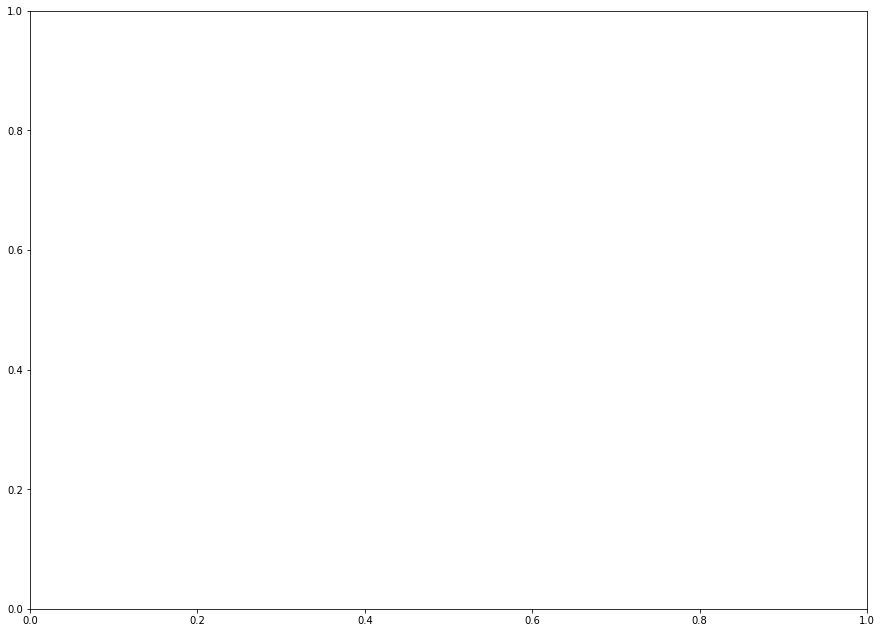

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 11))
def tmp():
  for key in history.keys():
    yield key, history[key]['training loss'], 'training loss'
    yield key, history[key]['validation loss'], 'validation loss'
    for i in range(1000):
      itm = 'KITTI loss {}'.format(i)
      if itm not in history[key].keys():
        break
      yield key, history[key][itm], 'KITTI Route {}'.format(i + 1)
x, y, c = zip(*tmp())
sns.lineplot(x=x, y=y, hue=c, ax=axs)
sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=False)
axs.set_title('Loss During Training (MSE in MPH)')
axs.set_xlabel('Epoch')
axs.set_ylabel('MSE')
plt.savefig('history.jpg')
plt.show()

In [ ]:
data_loader = Dataset_Custom_Fast(comma_frames, comma_speeds)
data_loader = DataLoader(data_loader, batch_size=1, shuffle=False, drop_last=False)

model.eval()
pbar = tqdm(enumerate(data_loader), 'Making Predictions', total=len(data_loader), dynamic_ncols=True)
results = {
    'prediction':[],
    'actual':comma_speeds
}
for i, data in pbar:
  img, label = data
  if use_cuda:
    img.cuda()
    label.cuda()

  with torch.no_grad(): 
    #out = model(img, device)
    results['prediction'].insert(i, model(img, device))

for i in tqdm(range(len(results['prediction'])), 'Converting'):
  results['prediction'][i] = results['prediction'][i].cpu().tolist()[0]

#format for display
def tmp():
  for i in range(len(results['prediction'])):
    yield i, results['prediction'][i], 'Prediction'
  for i in range(len(results['actual'])):
    yield i, results['actual'][i], 'Actual'
x, y, c = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=True)
#sns.lineplot(x=x, y=y, hue=c, ax=axs, legend=True)
axs.set_xlabel('Time')
axs.set_ylabel('Speed')
plt.savefig('comparison.jpg')
plt.show()

In [ ]:
for k in range(9, len(history), 10):
  model.load_state_dict(history[k + 1]['weights'])
  kitti_results = list()
  for j in range(len(kitti_frames)):
    data_loader = Dataset_Custom_Fast(kitti_frames[j], kitti_speeds[j])
    data_loader = DataLoader(data_loader, batch_size=1, shuffle=False, drop_last=False)

    model.eval()
    pbar = tqdm(enumerate(data_loader), 'Making Predictions', total=len(data_loader), dynamic_ncols=True)
    kitti_results.append({
        'prediction':[],
        'actual':kitti_speeds[j]
    })
    for i, data in pbar:
      img, label = data
      if use_cuda:
        img.cuda()
        label.cuda()

      with torch.no_grad(): 
        #out = model(img, device)
        kitti_results[j]['prediction'].insert(i, model(img, device) * FRAME_RATE_2/FRAME_RATE_1)

    for i in tqdm(range(len(kitti_results[j]['prediction'])), 'Converting'):
      kitti_results[j]['prediction'][i] = kitti_results[j]['prediction'][i].cpu().tolist()[0]

    #format for display
    def tmp():
      for i in range(len(kitti_results[j]['prediction'])):
        yield i, kitti_results[j]['prediction'][i], 'Prediction'
      for i in range(len(kitti_results[j]['actual'])):
        yield i, kitti_results[j]['actual'][i], 'Actual'
    x, y, c = zip(*tmp())

    fig, axs = plt.subplots(1, 1, figsize=(15, 11))
    sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=True)
    #sns.lineplot(x=x, y=y, hue=c, ax=axs, legend=True)
    axs.set_title('KITTI route {} epoch {}'.format(j + 1, k + 1))
    axs.set_xlabel('Time')
    axs.set_ylabel('Speed')
    plt.savefig('comparison.jpg')
    plt.show()

In [ ]:
for k in range(9, len(history), 10):
  #format for display
  def tmp():
    for j in range(len(kitti_frames)):
      for i in range(len(kitti_results[j]['prediction'])):
        yield kitti_results[j]['actual'][i], kitti_results[j]['prediction'][i] - kitti_results[j]['actual'][i], 'KITTI Route {}'.format(j + 1)
  x, y, c = zip(*tmp())

  fig, axs = plt.subplots(1, 1, figsize=(15, 11))
  sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=True)
  #sns.lineplot(x=x, y=y, hue=c, ax=axs, legend=True)
  axs.set_title('KITTI Epoch {} Speed vs. Error'.format(k + 1))
  axs.set_xlabel('Speed')
  axs.set_ylabel('Error')
  plt.show()

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield i, results['prediction'][i] - results['actual'][i]
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Time')
axs.set_ylabel('Error')
axs.set_title('Error vs. Time')
plt.show()

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield i, np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Time')
axs.set_ylabel('Absolute Error')
axs.set_title('Absolute Error vs. Time')
plt.show()

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], results['prediction'][i] - results['actual'][i]
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Actual Speed')
axs.set_ylabel('Error')
axs.set_title('Error vs. Actual Speed')
plt.show()

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Actual Speed')
axs.set_ylabel('Absolute Error')
axs.set_title('Absolute Error vs. Actual Speed')
plt.show()

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.kdeplot(x=t, y=err, ax=axs)
axs.set_xlabel('Actual Speed')
axs.set_ylabel('Absolute Error')
axs.set_title('Absolute Error vs. Actual Speed Distribution')
plt.show()

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.kdeplot(x=err, ax=axs)
#axs.set_xlabel('Actual Speed')
axs.set_xlabel('Absolute Error')
axs.set_title('Absolute Error Distribution')
plt.show()